# HW 1 - Data Platform IDC
ID1: 308564293

ID2: 311898746

## Step 1: Setup Cassandra Cluster locally -

> Code is in markdown as we don't want to run this from the notebook
> The setup is oriented for mac env

Make sure Docker Desktop is installed. If not, download and install Docker from the official website [Get Docker | Docker Docs](https://docs.docker.com/get-docker/).

Download docker image for cassandra
```bash
docker pull cassandra:latest
```

Run container locally open for conncetion from the notebook
```bash
docker run --volume=/var/lib/cassandra --restart=no -p 127.0.0.1:9042:9042 -p 127.0.0.1:9160:9160 --name hw-cass -d cassandra:latest
```

Connect to run `cqlsh` locally
```bash
docker exec -it hw-cass cqlsh
```

## Step 2: Setup python environment

install python
```bash
brew install python
```

install required libraries

Install libraries
```bash
pip3 install -r requirements.txt
```

In [2]:
# Cassandra-driver
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement, BatchStatement

# Data
import csv
import pandas as pd
import concurrent.futures
from collections import namedtuple

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns


# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 3: Choosing the dataset

##### Data set content - [Dataset link.](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)
The Book-Crossing dataset has 3 files and is given in .csv form.


`Users` Has 3 colums:
* User-ID (int): Anonymized user identifier mapped to integers.
* Location (text): Demographic information about the user's location.
* Age (float): Age of the user. May contain NULL-values if not available.

Rows:  279K, each identifing a user.

`Books` Has 8 columns:
* SBN (text): Unique identifier for each book.
* Book-Title (text): Title of the book.
* Book-Author (text): Author of the book. In case of multiple authors, only the first one is provided.
* Year-Of-Publication (int): The year when the book was published.
* Publisher (text): The publisher of the book.
* Image-URL-S, Image-URL-M, Image-URL-L (text): URLs linking to cover images in small, medium, and large sizes.

Rows: 271K, that identify books.

`Ratings` Has 3 columns:
* User-ID (int): Anonymized user identifier corresponding to Users table.
* ISBN (text): Unique identifier corresponding to Books table.
* Book-Rating (int): User's rating for a particular book. Explicit ratings are on a scale from 1-10, while implicit ratings are expressed as 0.

Rows: 1.14M, each representing an interaction where a user rated a specific (single) book.


#### Dataset Selection
* The dataset was selected for it's very large size (14 columsn and over 1.5M rows) that will allow us to explore Cassandra's strengths with large datasets.
* The dataset is also realistic, reflecting a real-life scenario of different data soruces and systems that are interconnected. 
* Data is relatively well organized and clean.

**In this project:** The data set is stored in the `Data` folder - where the names of the files are corresponding to the explnation above.

## Step 4: Cassendra Database design

##### Databse Design
The DB will be designed in accordance to the queries that we will want to run:
* Queries related to the books rating, number of rates, avg rating.
* Queries related to authors, most rated authors, highest rated authors.
* Most active users (users with highest rating counts) and their locations.

From this the structure of the DB will be built to reflect these queries. 
`books` and `users` will be tables that correspond to a database of books and users with their full information.

`books_rated_by_user` will contain each transaction (rating event) keyed by the book ID. Similalry, `users_by_rated_books` will contrain the same transaction information but keyed by the user.

This will allow us to access data based on book ID or user ID and also preform aggregations on each of the partition keys.

##### `books`
* **Structure**: ISBN: text, Book-Title: text, Book-Author: text, Yop (year of publication): int, Publisher: text, Image-URL-S: text, Image-URL-M: text, Image-URL-L: text
* **Primary key**: (ISBN)
* **Partition Key**: ISBN
* **Clustering Column**: None

ISBN is a unique identifier per book so it will be the partition key.


##### `users`
* **Structure**: User-ID: int, Location: text, Age: int 
* **Primary key**: (User-ID)
* **Partition Key**: User-ID
* **Clustering Column**: None

User-ID is a unique identifier per user so it will be the partition key.

##### `books_rated_by_user`
* **Structure**: User-ID: int, Age: int, location: text, isbn: text, book_author: text, yop: int, publisher: text, book_rating: int
* **Primary key**: ((ISBN), location, User-ID)
* **Partition Key**: ISBN
* **Clustering Column**: location, User-ID

User-ID and ISBN are unique identifiers for a transaction assuming that each user rates a book once, so they are the primary key. 
ISBN is selected to be the partition key to allow aggregation by book.

##### `users_by_rated_books`
* **Structure**: User-ID: int, Age: int, location: text, isbn: text, book_author: text, yop: int, publisher: text, book_rating: int
* **Primary key**: ((User-ID), book_author, ISBN)
* **Partition Key**: User-ID
* **Clustering Column**: ISBN, book_author

Data structure is similar to `books_rated_by_user` with the exception of User-ID as the partition key. This is to allow aggregation of transactions by user. Also book_author is a clustering column.

we would like to investigate more about the relatinship between the users, the books and the ratings.
Since we are using cassandra, we will have to create another table that will represent some of this relationship, so we wont need to do this calcualtion in memory.

##### `ratings_by_age`
* **Structure**: user_id: int, isbn: text, book_rating: int, age: int, age_group: text, book_author: text, publisher: text
* **Primary key**: ((age_group), book_author, isbn, user_id)
* **Partition Key**: age_group
* **Clustering Column**: book_author, isbn, user_id

This table will allow us to query and group rows by age_group and by author.
We are assuming here that author will have low cardinality therefore we can use simple aggerative queries to return only the aggregated amount of data.

We chose this format since for every new rating, it is easy to insert the record, and no enrichment or fetching and maintaion data is required.


## Step 5: Setup keyspace and tables

First - We would like to load all the libraries need for ingestion and working with the cassandra DB

Connect to our cassandra instance.

In [6]:
# Connect Cassandra-Driver to the Cluster running on the Docker:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

Create out key space `books`.
We will use `SimpleStrategy` and `replication_factor` = `1` as they serve us well for the purpose of this excsrsize - as we are not looking for any HA or significant scale

In [7]:
session.execute("CREATE KEYSPACE IF NOT EXISTS books WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

Make sure keyspace created

In [8]:
session.execute("DESCRIBE books;").one()[3]

"CREATE KEYSPACE books WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '1'}  AND durable_writes = true;"

Use the keyspace

In [9]:
session.execute("USE books");

##### Table creation: 
Next, we will create the tables according to the DB schema.

In [7]:
session.execute("""
    CREATE TABLE IF NOT EXISTS books (
        ISBN text,
        Book_Title text,
        Book_Author text,
        Publisher text,
        YOP int,       
        Image_URL_S text,
        Image_URL_M text,
        Image_URL_L text,
        PRIMARY KEY ((isbn))
    )
""").one()

In [8]:
session.execute("""
    CREATE TABLE IF NOT EXISTS users (
        age float,
        location text,
        user_id int,
        PRIMARY KEY(user_id)
    )
""").one()

In [77]:
session.execute("""
    CREATE TABLE IF NOT EXISTS books_rated_by_users (
        user_id   int,
        age int,
        location text,
        isbn   text,
        book_author text,
        yop int,
        publisher text,
        book_rating int,
        primary key ((isbn), location, user_id)
    )
""").one()

In [10]:
session.execute("""
    CREATE TABLE IF NOT EXISTS users_by_rated_books (
        user_id   int,
        age int,
        location text,
        isbn   text,
        book_author text,
        yop int,
        publisher text,
        book_rating int,
        primary key ((user_id), book_author, isbn)
    )
""").one()

In [12]:
session.execute("""
    CREATE TABLE IF NOT EXISTS ratings_by_age (
        user_id int,
        isbn text,
        book_rating int,
        age int,
        age_group text,
        book_author text,
        publisher text,
        primary key ((age_group), book_author, isbn, user_id)
    )
    """).one()

##### Validation:

In [13]:
session.execute("""DESCRIBE tables;""").all()


[Row(keyspace_name='books', type='table', name='books'),
 Row(keyspace_name='books', type='table', name='books_rated_by_user'),
 Row(keyspace_name='books', type='table', name='books_rated_by_users'),
 Row(keyspace_name='books', type='table', name='ratings_by_age'),
 Row(keyspace_name='books', type='table', name='users'),
 Row(keyspace_name='books', type='table', name='users_by_rated_books')]

## Step 6: Data ingestion

#### 6.1: CSV Import
We will start by importing the .csv files into a dataframe and casting to the correct dtype.

In [14]:
Files = namedtuple("Files", "users ratings books")

files = Files(
    users='Data/Users.csv',
    ratings='Data/Ratings.csv',
    books='Data/Books.csv'
)

# Specify data types for each column
books_data_types = {
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': int,  
    'Publisher': str,
    'Image-URL-S': str,
    'Image-URL-M': str,
    'Image-URL-L': str,
}

users_data_types = {
    'User-ID': int,
    'Location': str,
    'Age': float,  
}

ratings_data_types = {
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int,
}


df_books = pd.read_csv(files.books, dtype=books_data_types)
df_users = pd.read_csv(files.users, dtype=users_data_types)
df_ratings = pd.read_csv(files.ratings, dtype=ratings_data_types)

# clean whitespaces
df_books.columns = df_books.columns.str.strip()


Note - If that CSV files were bigger, we would have to work in chunks in loading the df.

##### Prepare data for `books_rated_by_user`:

Next, we will merge and filter the dataframes to generate the data for the `books_rated_by_user` and `users_by_rated_books` tables, that are a join of the `ratings`, `users` and `books` .csv files. We will use the inner join to keep only rows with valid data.

In [18]:
# Merge df_ratings with df_users on 'user_id'
df_merged = pd.merge(df_ratings, df_users, on='User-ID', how='inner')

# Merge the result with df_books on 'isbn'
df_merged = pd.merge(df_merged, df_books, on='ISBN', how='inner')

# Select the desired columns for the new DataFrame
df_merged = df_merged[['User-ID', 'Age', 'Location', 'ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]

# Remove rows with NaN values except for the 'Age' column from the existing DataFrame
# this is useful since we have ratings for bools that not exist, this is less relevant for us
df_merged.dropna(subset=df_merged.columns.difference(['Age']), inplace=True)

*Validate:*

We should only have NaN in the `age` collumn, other collumns shouldn't have NaN.

In [19]:
df_merged.isna().sum()

User-ID                     0
Age                    277835
Location                    0
ISBN                        0
Book-Author                 0
Year-Of-Publication         0
Publisher                   0
Book-Rating                 0
dtype: int64

##### Prepare data for `ratings_by_age`:

In [26]:
# fill age NaN to zero as it is the primary key
df_merged_fill_age = df_merged.fillna(0)

df_merged_fill_age = df_merged_fill_age[['User-ID', 'ISBN', 'Book-Rating', 'Age', 'Book-Author', 'Publisher']]

df_rating_by_age = df_merged_fill_age[df_merged_fill_age['Book-Rating'] > 0].copy()

age_bins = [0, 18, 30, 40, 50, 60, 70, float('inf')]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71+']

# Add the "age range" column to the DataFrame
df_rating_by_age.loc[:, 'age_group'] = pd.cut(df_rating_by_age['Age'], bins=age_bins, labels=age_labels, right=False)

Now the data is ready in the various dataframes and is prepared for ignestion.

#### 6.2 Data Ingestion function

`df_load_data` function reads data from DF, splits it into batches, and inserts the data into a cassandra table.

Batches are important for improving the performance and efficiency of inserting large amounts of data into a database table. They are generated using Cassandra Driver `BatchStatement()`.

The data is cast to the type using a list that specifies dtypes.

When inserting data into a database table, it is possible to insert row by row, or to insert multiple rows at once as a batch. Inserting data in a batch greatly improves the performance of inserting data into the database, as it reduces the number of round trips to the database and can ensure that the data is consistent. This is more efficient than inserting one row at a time, which can be slow and can lead to unnecessary overhead.

In [15]:
import concurrent.futures

# TODO: improve the data casting
# Helper function to construct the batch operation and then run concurrently
def df_load_data(df, insert_query, data_types, batch_size=100, max_batches=None, concurrency=1):
    '''Load data from a DataFrame into a Cassandra table using batch inserts.
        Inputs:
        1. df: pandas DataFrame
            DataFrame containing the data to be inserted.
        2. insert_query: str
            CQL query for inserting data into the Cassandra table.
        3. data_types: list
            List of data types corresponding to the columns in the DataFrame.
        4. batch_size: int, optional (default=100)
            Number of rows in each batch.
        5. max_batches: int, optional (default=None)
            Number of batches tp insert.

        Returns: None
    '''
    
    # Helper functions
    def convert_data(row):
        # Convert a single row's data to the correct format according to the data_types
        converted_data = [data_type(value) if pd.notna(value) else data_type() for value, data_type in zip(row, data_types)]
        return tuple(converted_data)

    def import_batch(rows):
        # Build a batch statement for the current set of rows (single batch)
        batch = BatchStatement()
        for row in rows.itertuples(index=False):
            # Convert data types
            try:
                converted_row = convert_data(row)
                #converted_row = row
                #print(row)
                # Create the query and add it to the batch
                batch.add(insert_query, converted_row)
            except Exception as e:
                print(f"error on row: {row}, skipping")
                raise
        session.execute(batch, trace=True)

    # Function body
    # split DataFrame to batches
    df_split = [df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size)][:max_batches]

    if concurrency == 1:
        for batch in df_split:
            import_batch(batch)
    else:
        with concurrent.futures.ThreadPoolExecutor(max_workers=concurrency) as executor:
            executor.map(import_batch, df_split)

A helper function to cound the number of rows inserted to a cassandra table:

In [27]:
def num_of_records(table):
    count_query = f"SELECT COUNT(1) FROM {table}"
    result = session.execute(count_query)
    return result.one().count

#### 6.3 Data Ingestion
Now we will ingest the data using the `df_load_data` fucntion and validate for each table that the number of rows matches the number in the CSV.

##### `books`:

In [23]:
## books table
# Insertion Query
books_query = """
            INSERT INTO books (ISBN, Book_Title, Book_Author, yop, Publisher, Image_URL_S, Image_URL_M, Image_URL_L)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
books_data_types = [str, str, str, int, str, str, str, str] 

df_load_data(df_books, books_query, books_data_types)

*Validation:*

In [17]:
# Row count validation
cass_len = num_of_records("books")

assert cass_len == df_books.shape[0]

##### `users`:

In [28]:
# Insertion Query
users_query = """
                INSERT INTO users (User_ID, Location, Age)
                VALUES (%s, %s, %s)
                """

# A list of data types for this table
users_data_types = [int, str, float]  # User_ID, Location, Age

# load data
df_load_data(df_users, users_query, users_data_types)

*Validation:*

In [18]:
# Row count validation
cass_len = num_of_records("users")

assert cass_len == df_users.shape[0]

##### `books_rated_by_user`:

In [44]:
## books_rated_by_user table
# Insertion Query
books_rated_by_user_query = """
            INSERT INTO books_rated_by_user (User_ID, Age, Location, ISBN, Book_Author,
            yop, Publisher, Book_Rating)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
brbu_data_types = [int, int, str, str, str, int, str, int]  

# load data
df_load_data(df_merged,books_rated_by_user_query, brbu_data_types)

*Validation:*

In [19]:
# Row count validation
cass_len = num_of_records("books_rated_by_user")

assert cass_len == df_merged.shape[0]

##### `users_rated_by_books`:

In [46]:
# Insertion Query
users_by_rated_books_query = """
            INSERT INTO users_by_rated_books (User_ID, Age, Location, ISBN, Book_Author,
            yop, Publisher, Book_Rating)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
brbu_data_types = [int, int, str, str, str, int, str, int]  

# load data
df_load_data(df_merged,users_by_rated_books_query, brbu_data_types)

*Validation:*

In [20]:
# Row count validation
cass_len = num_of_records("users_by_rated_books")

assert cass_len == df_merged.shape[0]

##### `ratings_by_age`:

In [28]:
# Insertion Query
ratings_by_age_query = """
            INSERT INTO ratings_by_age (User_ID, ISBN, book_rating, age, book_author, publisher, age_group)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
ratings_by_age_data_types = [int, str, int, int, str, str, str]  

# load data
df_load_data(df_rating_by_age, ratings_by_age_query, ratings_by_age_data_types, concurrency=4)

*Validation:*

In [30]:
# Row count validation
cass_len = num_of_records("ratings_by_age")

assert cass_len == df_rating_by_age.shape[0]

## Step 7: Data investigation

#### 7.1 Books and Rankings:
We will start by investigating the book's rankings. We will query for each book how many rankings exist and what is the average ranking score.

In [106]:
# query the average book rating and nunmber of ratings per book
result = session.execute("""
        SELECT isbn, AVG(book_rating) as rating_avg, COUNT(book_rating) as rating_count
        FROM books_rated_by_user
        GROUP BY isbn;
                """)

# Insert to DF
df_book_rating = pd.DataFrame(result.all(), columns=['isbn', 'rating_avg', 'rating_count'])

*Top 10 Books*

For better analysis we will add a column for `normalzied_score` which is the avergae ranking times the number of times a book was ranked. Then we will find the top 10 books by the number of ratings, and by normalized score, for the latter taking into account books ranked 6 or higher.

In [141]:
# Add normalized score
df_book_rating['normalized_score'] = df_book_rating['rating_count'] * df_book_rating['rating_avg']

#top 10 books by number of rankings
df_top_10_by_rankings = df_book_rating.sort_values(by='rating_count', ascending=False).head(10)

df_top_10_by_normalized_score = df_book_rating[df_book_rating['rating_avg'] > 6]\
    .sort_values(by='normalized_score', ascending=False).head(10)

For each of the top 10 books we will add additional data from the `books` table using a dedicated query.

We will start with a helper function to query the additional data from the `books` table.

In [125]:
# Helper function to query book data from cassandra
def get_book_data(session, isbn):
    query = f"SELECT book_author, yop, book_title FROM books WHERE isbn = '{isbn}'"
    result = session.execute(query)
    pd_result = pd.DataFrame(result.all(), columns=['book_author', 'yop', 'book_title'])
    return pd_result

# Add additional data for the top 10 by rankings dataframe
def add_data_by_isbn(df,session):
    for isbn in df['isbn']:
        df_book_data = get_book_data(session, isbn)
        df.loc[df['isbn'] == isbn, ['book_author', 'yop', 'book_title']] = df_book_data.values
    return df

Next we will insert the additional data to the `df_top_10_by_rankings` and `df_top_10_by_normalized_score` dataframes.

In [197]:
df_top_10_by_normalized_score = add_data_by_isbn(df_top_10_by_normalized_score, session);
df_top_10_by_rankings = add_data_by_isbn(df_top_10_by_rankings, session);

Finally we can display the results:

In [198]:
print('Top 10 books by normalized score:')
display(df_top_10_by_normalized_score[['book_title', 'book_author', 'yop', 'normalized_score']].rename_axis('ISBN', axis=1))

print('Top 10 books by rating count score:')
display(df_top_10_by_rankings[['book_title', 'book_author', 'yop', 'rating_count']].rename_axis('ISBN', axis=1))

Top 10 books by normalized score:


ISBN,book_title,book_author,yop,normalized_score
227261,Free,Paul Vincent,2003.0,378
181649,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,1974.0,231
214857,El Hobbit,J. R. R. Tolkien,1991.0,161
42406,A Kiss for Little Bear,Else Holmelund Minarik,1984.0,140
192621,Bad Business,Robert B. Parker,2004.0,140
46769,Fox in Socks (I Can Read It All by Myself Begi...,Dr. Seuss,1965.0,133
29730,Marching Through Culpeper : A Novel of Culpepe...,Virginia Beard Morton,2000.0,120
233292,There's Treasure Everywhere--A Calvin and Hobb...,Bill Watterson,1996.0,119
93704,All-American Girl,Meg Cabot,2002.0,119
108382,Die unendliche Geschichte: Von A bis Z,Michael Ende,1979.0,112


Top 10 books by rating count score:


ISBN,book_title,book_author,yop,rating_count
145409,Wild Animus,Rich Shapero,2004.0,2502
102769,The Lovely Bones: A Novel,Alice Sebold,2002.0,1295
258580,The Da Vinci Code,Dan Brown,2003.0,883
138240,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,732
228732,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,723
94421,A Painted House,John Grisham,2001.0,647
87511,The Secret Life of Bees,Sue Monk Kidd,2003.0,615
61930,Snow Falling on Cedars,David Guterson,1995.0,614
36696,Angels &amp; Demons,Dan Brown,2001.0,586
44090,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998.0,585


*Rating vs. Rating count*

Next, We will investigate the relation between the number of ratings a book has and it's average user rating.

c:\Users\Jonathan\Documents\GitHub\DataPlatHW\.conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


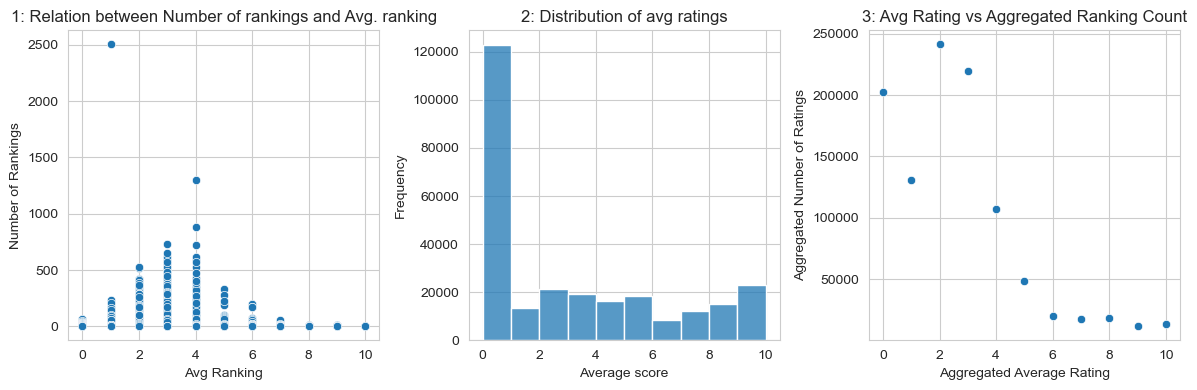

In [228]:
# sns setup
plt.figure(figsize=(12, 4)) 

# Graph 1: the relation between avg ranking and number of rankings
plt.subplot(1, 3, 1)
sns.scatterplot(y='rating_count', x='rating_avg', data=df_book_rating)
plt.title('1: Relation between Number of rankings and Avg. ranking')
plt.ylabel('Number of Rankings')
plt.xlabel('Avg Ranking')

# Graph 2: Histogram showing the distribution of ratings
plt.subplot(1, 3, 2)
sns.histplot(df_book_rating['rating_avg'], bins=10, kde=False)
plt.title('2: Distribution of avg ratings')
plt.xlabel('Average score')
plt.ylabel('Frequency')

# Graph 3: average rating vs aggregated rating count
agg_df = df_book_rating.groupby('rating_avg').agg({'rating_count': 'sum'}).reset_index()

# plot
plt.subplot(1, 3, 3)
sns.scatterplot(y='rating_count', x='rating_avg', data=agg_df)
plt.title('3: Avg Rating vs Aggregated Ranking Count')
plt.xlabel('Aggregated Average Rating')
plt.ylabel('Aggregated Number of Ratings')

# Show the plots
plt.tight_layout()
plt.show()


We reach a few conclusions:
* From 1, The number of people who rank each book behaves more or less like a right-tail normal distribution. This is not exactly a histogram since each point reprsents a single book with a ranking and a number of rankings.
* There is one outlier - a single book that had many "1" rankings. This is peculiar and perhaps some data error. (Or a very, very bad book)
* From graph 2, there are much more books with 0 ranking than any other rank. This can be a data error.
* From graph 3 we see the higher the average rating, the less people tend to actually rate it. Books with lower score had more ratings.
* This means people take the effort and write a review when the book is bad but not necassarily when the book is good. Or, that most books are pretty bad.

#### 7.2 Books and age:
In the next section we will explore the relation between the user base's age and book ratings, participation in ratings and author selection.

Run main query:

In [39]:
# avg book rating per age
result = session.execute("""
        SELECT age_group, book_author, count(book_rating) as num_of_ratings, avg(cast(book_rating as double)) as avarage_rating from ratings_by_age
        group by age_group, book_author;
""")
df_age_books = pd.DataFrame(result.all())

First look at to authors overall - By num of ratings, we can do this aggregation in memory easily,
We can see that `Stephen King` is really popular in terms of amount of raters.

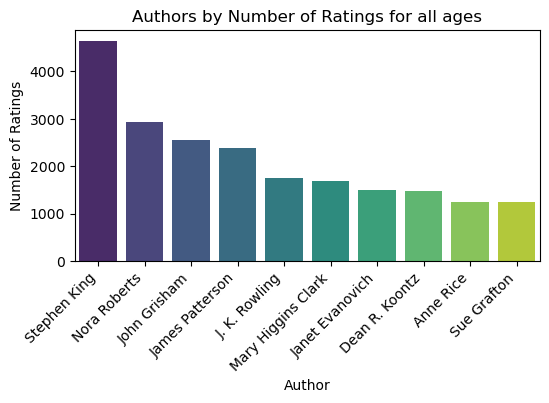

In [41]:
def top_authors_by_num_ratings(df, age_group=None, top_n=10):
    # Sort authors by the total number of ratings they received
    if not age_group:
        sorted_authors_by_ratings = df.groupby('book_author')['num_of_ratings'].sum().sort_values(ascending=False).reset_index()
    else:
        sorted_authors_by_ratings = df[df['age_group'] == age_group].sort_values(ascending=False, by='num_of_ratings').reset_index()
    top_10_authors_by_ratings = sorted_authors_by_ratings.head(top_n)


    # Plotting the results
    plt.figure(figsize=(6, 3))
    sns.barplot(x='book_author', y='num_of_ratings', data=top_10_authors_by_ratings, palette='viridis')
    plt.title(f'Authors by Number of Ratings for {age_group if age_group else "all ages"}')
    plt.xlabel('Author')
    plt.ylabel('Number of Ratings')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

    return top_10_authors_by_ratings


top_authors_by_num_ratings(df_age_books);

Now lets look at the top rated books

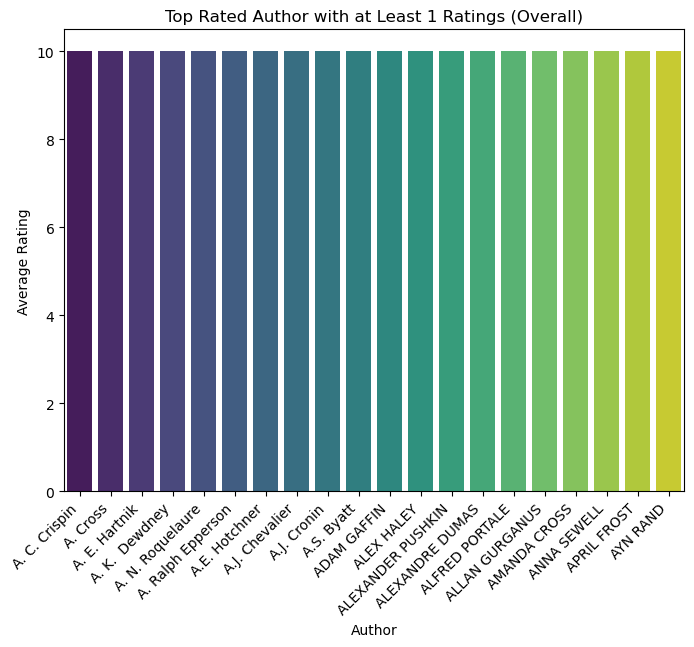

In [42]:

def top_rated_by_avg_rating(df, min_ratings=1, top_n=20):
    # TODO fix
 
    # Group by 'book_author' and calculate the total number of ratings for each author
    total_ratings_per_author = df.groupby('book_author')['num_of_ratings'].sum().reset_index()
    

    # Filter authors with at least min_ratings ratings
    filtered_authors = total_ratings_per_author[total_ratings_per_author['num_of_ratings'] >= min_ratings]

    # Find the top-rated author with at least min_ratings ratings
    top_rated_author = df[df['book_author'].isin(filtered_authors['book_author'])].nlargest(top_n, 'avarage_rating')[['book_author', 'avarage_rating','num_of_ratings']]
    
    # Plotting the results
    plt.figure(figsize=(8, 6))
    sns.barplot(x='book_author', y='avarage_rating', data=top_rated_author, palette='viridis')
    plt.title(f'Top Rated Author with at Least {min_ratings} Ratings (Overall)')
    plt.xlabel('Author')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()
    
    return top_rated_author

graph_data = top_rated_by_avg_rating(df_age_books, 1)

We will see there are lots of books rated with 10.0
but if we look at the data, we will see that most of those books only were rated limited amount of times

In [46]:
graph_data

,book_author,avarage_rating,num_of_ratings
8,A. C. Crispin,10.0,1
13,A. Cross,10.0,1
14,A. E. Hartnik,10.0,1
26,A. K. Dewdney,10.0,1
33,A. N. Roquelaure,10.0,1
36,A. Ralph Epperson,10.0,1
51,A.E. Hotchner,10.0,1
54,A.J. Chevalier,10.0,1
55,A.J. Cronin,10.0,1
62,A.S. Byatt,10.0,1


Lets only show the results of authors that were rated at least 500 times

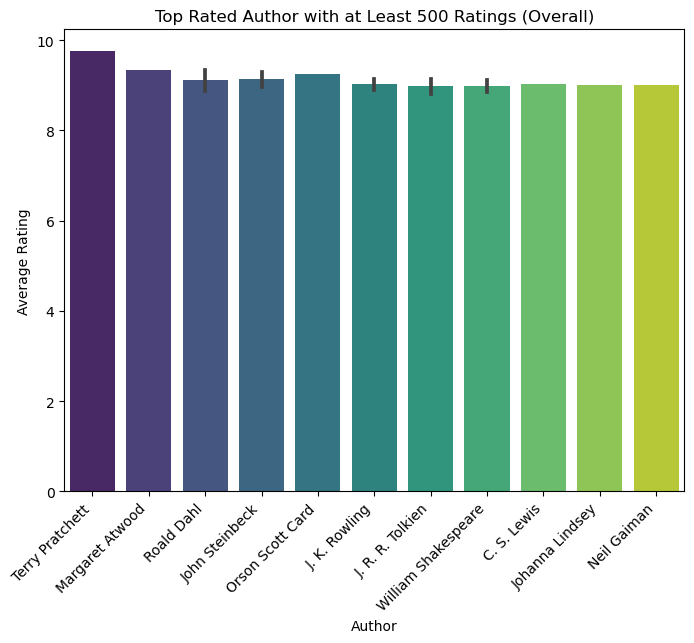

,book_author,avarage_rating,num_of_ratings
72867,Terry Pratchett,9.750000,12
97287,Margaret Atwood,9.333333,3
97637,Roald Dahl,9.333333,6
70879,John Steinbeck,9.300000,10
71913,Orson Scott Card,9.250000,4
7153,J. K. Rowling,9.158228,158
7178,J. R. R. Tolkien,9.136986,73
55973,J. K. Rowling,9.129204,565
111019,William Shakespeare,9.105263,38
103050,J. K. Rowling,9.092105,76


In [43]:
top_rated_by_avg_rating(df_age_books, 500)

Now lets dive into the age groups
What are the most rated authors per age group

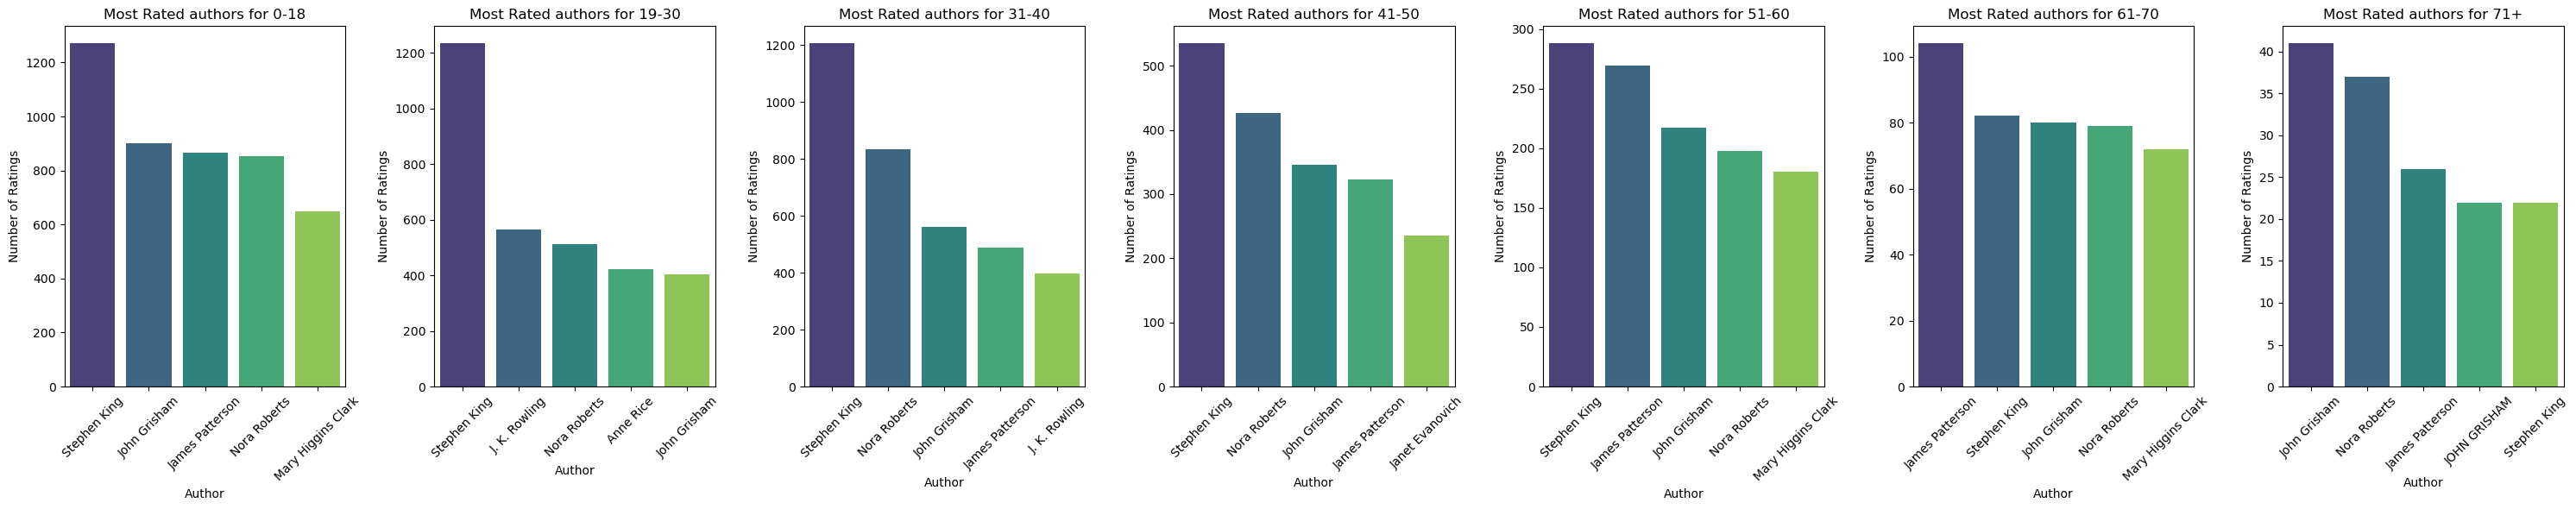

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 6))


def top_authors_by_popularity_group(df, idx, age_group=None):
    # Find the top-rated author overall
    # Sort authors by the total number of ratings they received
    if not age_group:
        sorted_authors_by_ratings = df.groupby('book_author')['num_of_ratings'].sum().sort_values(ascending=False).reset_index()
    else:
        sorted_authors_by_ratings = df[df['age_group'] == age_group].sort_values(ascending=False, by='num_of_ratings').reset_index()
    top_10_authors_by_ratings = sorted_authors_by_ratings.head(5)


    # Plotting the results
    # plt.figure(figsize=(5, 3))
    sns.barplot(x='book_author', y='num_of_ratings', data=top_10_authors_by_ratings, palette='viridis', ax=axes[idx])
    axes[idx].set_title("Most Rated authors for " + age_group)
    axes[idx].set_xlabel('Author')
    axes[idx].set_ylabel('Number of Ratings')
    axes[idx].tick_params(rotation=45, axis='x')  # Rotate x-axis labels for better readability


for i, age_label in enumerate(age_labels):
    top_authors_by_popularity_group(df_age_books, i, age_label)

plt.tight_layout()
plt.show()


Lets do the same with avarage ratings

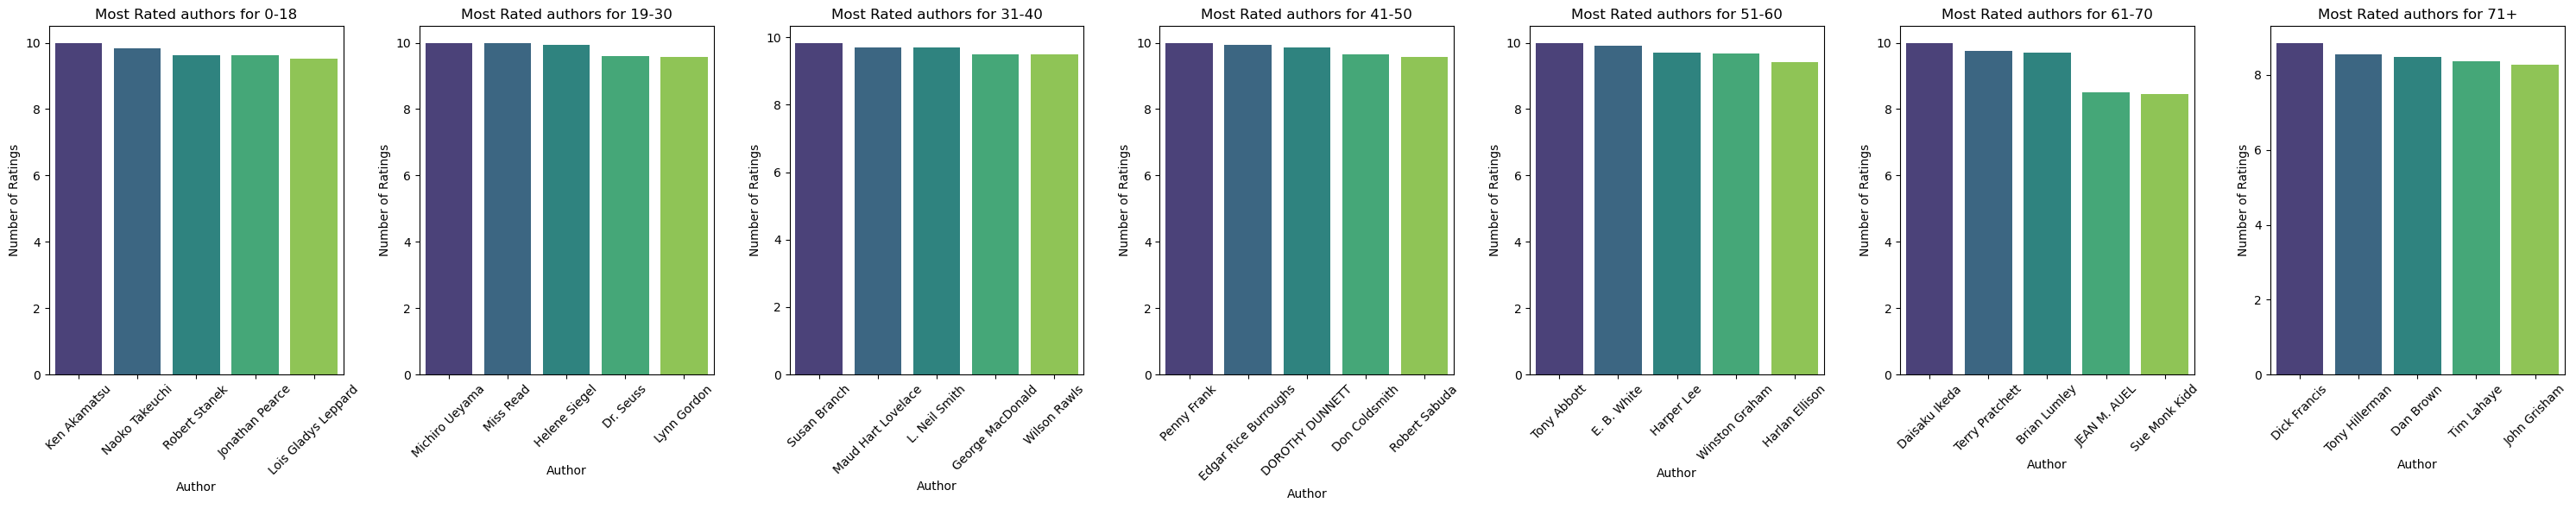

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 6))


def top_authors_by_avg_rating_group(df, idx, age_group=None, min_ratings=10):
    # Find the top-rated author overall
    # Sort authors by the total number of ratings they received
    
    filtered_age_group = df[df['age_group'] == age_group]
    filtered_age_group = filtered_age_group[filtered_age_group['num_of_ratings'] > min_ratings]
    sorted_authors_by_ratings = filtered_age_group.sort_values(ascending=False, by='avarage_rating').reset_index()
    


    top_10_authors_by_ratings = sorted_authors_by_ratings.head(5)


    # Plotting the results
    # plt.figure(figsize=(5, 3))
    sns.barplot(x='book_author', y='avarage_rating', data=top_10_authors_by_ratings, palette='viridis', ax=axes[idx])
    axes[idx].set_title("Most Rated authors for " + age_group)
    axes[idx].set_xlabel('Author')
    axes[idx].set_ylabel('Number of Ratings')
    axes[idx].tick_params(rotation=45, axis='x')  # Rotate x-axis labels for better readability


for i, age_label in enumerate(age_labels):
    top_authors_by_avg_rating_group(df_age_books, i, age_label)

plt.tight_layout()
plt.show()

### Conclutions
TODO

#### 7.3 Users behaviour:

In [67]:
# find locations of users with most rankings
result = session.execute("""
        SELECT user_id, location, COUNT(book_rating) AS rating_count
        FROM users_by_rated_books
        GROUP BY user_id;
                """)